# Solve Partial Differential Equation with Physics-Informed DeepONet(PI-DeepONet)

본 예제에서는 Physic-Informed DeepONet(PI-DeepONet)를 통해 Burger's Equation의 해를 계산하도록 훈련시키는 방법을 보여줍니다. 해당 코드는 "Learning the solution operator of parametric partial differential equations with physics-informed DeepONets"의 Section "Burgers transport dynamics"의 예제 코드를 바탕으로 구성되었습니다. 추후 다른 예제 코드가 궁금하실 경우 본문 하단에 논문과 예제 코드의 참조 링크 및 논문에서 제공하는 보충 데이터가 있으니, 참조 부탁 드립니다. 해당 논문에서 사용된 Burger's Equation의 형태는 아래와 같습니다.

\\

$$\frac{ds}{dt} + s\frac{ds}{dx} - ν\frac{d^2s}{dx^2},\quad (x,t) ∈ (0, 1) × (0, 1]$$
$$s(x, 0) = u(x), \quad x ∈ (0, 1)$$

\\
$t∈(0,1)$ 이며, 초기 조건 $u(x)$는 $GRF \sim 𝒩(0,25^2(−Δ + 5^2I)^{−4})$ 내에서 생성됩니다. 방정식의 점도 계수는 0.01의 값을 사용합니다. 경계조건은 주기 경계 조건(Periodic Boundary Condition)으로 설정합니다. 상세한 경계조건은 아래와 같습니다.

\\
$$s(0,t) = s(1,t),$$
$$\frac{ds}{dt}(0,t)=\frac{ds}{dt}(1,t)$$

\\
본 예제 코드는 PI-DeepONet을 사용하여 초기 조건 $u(x)$를 1D Burger's Equation의 전체 시공간 솔루션 $s(x,t)$에 매핑하는 솔루션 연산자를 학습합니다.

## Contact Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/My Drive/Burger"

/content/drive/My Drive/Burger


### jax

구글에서 만든 라이브러리로 Autobrad와 XLA(Accelerate Linear Algebra)를 이용해 만든 프레임워크입니다. Numpy 대신 활용 가능하고, CPU,GPU,TPU에서 코드 변경 없이 사용이 가능합니다. 빠르다는 장점으로 인해 현재 점차적으로 머신러닝에서 활용이 되고 있습니다.

\
random : 무작위 난수를 생성하는 모듈
\
grad : 함수를 미분하기 위한 모듈
\
vmap : 벡터화 매핑(배열 연산과 관련하여 함수를 배열의 각 요소에 대해 자동으로 벡터화)를 제공하는 모듈
\
jit : Just-In-Time(JIT) 컴파일을 제공하는 모듈, 이로 인해 함수를 효율적으로 최적화된 컴파일 버전으로 변환하고, 더 빠르고 최적화된 수치 연산 실행 가능
\
optimizers : 최적화와 관련된 모듈
\
config : jax 라이브러리의 구성 설정에 관련된 기능을 제공하는 모듈
\
ravel_pytree : 데이터를 구성하는 복잡한 구조들을 1D 배열로 flatten 시켜주는 모듈
\
relu, elu : 활성화 함수 제공하는 모듈


In [ ]:
import numpy as onp
import scipy.io
from scipy.interpolate import griddata
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.config import config
from jax.flatten_util import ravel_pytree
from jax.nn import relu, elu
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt

%matplotlib inline

## Define Model

PI-DeepONet 모델을 학습시키기에 앞서 해당 모델에 사용되는 다층 퍼셉트론 모델과 Data Generator를 정의해줍니다.


### Multi-Layer Perceptron(MLP)

다층 퍼셉트론(Multi-layer perceptron,MLP)는 여러 개의 퍼셉트론 뉴런을 여러 층으로 쌓은 다층신경망 구조로, 입력층과 출력층 사이에 하나 이상의 은닉층을 가지고 있는 신경망입니다. 흔히 역전파를 사용하여 비선형 데이터를 해석하기 위해 사용됩니다. 본 예제 코드에서는 MLP 외에도 Modified MLP 모델을 넣어, 둘 중 하나를 택해 사용할 수 있습니다. 코드와 같이 제공된 예제 파일 또한 두 모델에 대한 결과가 존재합니다.

\
Modified MLP 모델을 MLP 모델과 비교할 때 장점은 아래와 같습니다.

\
1. 더 강력한 비선형성
2. 복잡한 문제에 적합
3. 모델의 유연성 향상
4. 모델의 표현 능력 증가

\
Modified MLP 모델의 구조는 아래와 같습니다.

$$ U = \phi(XW^1+b^1), V = \phi(XW^2+b^2) $$
$$ H^{(1)}=\phi(XW^{z,1}+b^{z,1}) $$
$$ Z^{(k)}=\phi(H^{(k)}W^{z,k}+b^{z,k}), k = 1,...,L $$
$$ H^{(k+1)}=(1-Z^{(k)})⊙U+Z^{(k)}⊙V, k=1,...,L $$
$$ f_{\theta}(x)=H^{(L+1)}W+b $$

In [ ]:
# Define MLP
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b   ####################################
          inputs = activation(outputs)    ######################################
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply


# Define modified MLP
def modified_MLP(layers, activation=relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

  def init(rng_key):
      U1, b1 =  xavier_init(random.PRNGKey(12345), layers[0], layers[1])  #####
      U2, b2 =  xavier_init(random.PRNGKey(54321), layers[0], layers[1])  #####
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2)

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
      U = activation(np.dot(inputs, U1) + b1)   ################################
      V = activation(np.dot(inputs, U2) + b2)   ################################
      for W, b in params[:-1]:
          outputs = activation(np.dot(inputs, W) + b)   ########################
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V)  ######
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply


### Physics-Informed DeepONet

Physics-Informed DeepONet의 클래스를 정의합니다.
PI-DeepONet을 구성하는 Branch Network와 Trunk Network를 앞서 정의한 modified_MLP를 통해 초기화 후 활성화 함수를 지정해줍니다. 마찬가지로 optimizier를 초기화 합니다. 이 때 adam 최적화 알고리즘이 사용이 됩니다.

In [ ]:
# Define Physics-informed DeepONet model
class PI_DeepONet:
    def __init__(self, branch_layers, trunk_layers):
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = modified_MLP(branch_layers, activation=np.tanh)
        self.trunk_init, self.trunk_apply = modified_MLP(trunk_layers, activation=np.tanh)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3,
                                                                      decay_steps=2000,
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
        self.loss_ics_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

#### Operator Net

DeepONet 구조에서 가장 핵심적인 Operator Net을 정의해줍니다.
self.branch_apply, self.trunk_apply를 거침으로써, u와 y에 대한 결과값인 B와 T를 반환합니다. 이 두 결과를 각 요소별로 곱한 뒤 더하는 과정을 거쳐 최종 Output이 결정됩니다. 이 과정이 Brunch Network와 Trunk Network가 곱해져 솔루션의 연산자를 생성하는 Operator의 주요 개념이 적용된 부분이라고 볼 수 있습니다.

In [ ]:
    # Define DeepONet architecture
    def operator_net(self, params, u, t, x):
        branch_params, trunk_params = params
        y = np.stack([t,x])
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return   outputs

#### Loss_res

Loss_res는 방정식의 물리적 정보를 고려하기 위해 추가되는 손실함수 입니다. 해당 손실함수는 기본 PDE의 제약 조건을 적용합니다.

\\
PI-DeepONet의 솔루션 연산자가 $G_{\theta}$ 일 때 입력 함수 $u^{(i)}$에 대한 PDE의 잔차는 아래의 식과 같이 결정됩니다.

\\
$$R_{\theta}^{(i)}(x,t) = \frac{dG_{\theta}(u^{(i)})(x,t)}{dt}+G_{\theta}(u^{(i)})(x,t)\frac{dG_{\theta}(u^{(i)})(x,t)}{dx}-ν\frac{d^2G_{\theta}(u^{(i)})(x,t)}{dt^2}$$

\\
이 때 $u(i)$는 [0,1]의 공간에서 균일한 간격으로 배치된 고정 센서 $\lbrace x_{i} \rbrace^m_{i=1}$를 평가한 입력 함수입니다.

\\
$$\mathcal{L}_{physics}({\theta})=\frac{1}{NQ}\sum_{i=1}^{N}\sum_{j=1}^{Q}\left|R_{\theta}^{(i)}(x_{r,j}^{(i)},t_{r,j}^{(i)})\right|^2.$$

\\
이 때 N은 training Data의 sample 수이며, Q는 PDE 잔차를 평가할 Location의 수입니다.

\\
17번째 line의 코드를 통해 간단하게 vmap의 사용법을 알 수 있습니다. vmap을 통하여 self.residual_net을 벡터화를 합니다. 이 때 (None,0,0,0)은 매핑할 입력 배열 축(in_axes)가 지정됩니다. 뒤에 있는 (params,u,y[:,0],y[:,1])을 통해 residual_net의 입력 인자를 지정해 준 뒤, residual_net에서 operator_net을 거쳐 $\hat{R_{\theta}}$이 반환되어 이를 output과 비교하여 loss_res를 계산합니다.

In [ ]:
    # Define PDE residual
    def residual_net(self, params, u, t, x):
        s = self.operator_net(params, u, t, x)
        s_t = grad(self.operator_net, argnums=2)(params, u, t, x)
        s_x = grad(self.operator_net, argnums=3)(params, u, t, x)
        s_xx= grad(grad(self.operator_net, argnums=3), argnums=3)(params, u, t, x)

        res = s_t + s * s_x - 0.01 * s_xx
        return res

    # Define residual loss
    def loss_res(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss = np.mean((outputs.flatten() - pred)**2)
        return loss

#### Loss_ics

다음은 초기조건을 통해 계산하는 손실함수를 정의합니다. Loss_ics는 아래와 같습니다.

\\
$$\mathcal{L}_{IC}({\theta})=\frac{1}{NP}\sum_{i=1}^{N}\sum_{j=1}^{P}\left|G_{\theta}(u^{(i)})(x_{ic,j}^{(i)},0)-u^{(i)}(x_{ic,j}^{(i)})\right|^2.$$

\\
N은 Loss_res와 동일하게 training data의 sample 수이며, P는 초기 조건을 평가할 Location의 수입니다. 이 때 함수의 구성이 loss_res와 같은데, 추후 batch에 들어가는 데이터가 loss_res와는 다른 데이터가 들어가기 때문에 분리를 해줍니다.

In [ ]:
    # Define initial loss
    def loss_ics(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs

        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss = np.mean((outputs.flatten() - s_pred)**2)
        return loss

#### Loss_bcs

다음은 경계 조건으로부터 발생하는 손실함수 입니다. 먼저 손실함수의 식은 다음과 같습니다.

\\
$$\mathcal{L}_{BC}({\theta})=\frac{1}{NP}\sum_{i=1}^{N}\sum_{j=1}^{P}\left|G_{\theta}(u^{(i)})(0,t_{bc,j}^{(i)})-G_{\theta}(u^{(i)})(1,t_{bc,j}^{(i)})\right|^2+\frac{1}{NP}\sum_{i=1}^{N}\sum_{j=1}^{P}\left|\frac{dG_{\theta}(u^{(i)})(x,t)}{dx}\vert_{(0,t_{bc,j}^{(i)})}-\frac{dG_{\theta}(u^{(i)})(x,t)}{dx}\vert_{(1,t_{bc,j}^{(i)})}\right|^2$$

\\
N은 위의 손실함수들과 동일하게 training data의 sample 수이며, P는 경계 조건을 평가할 Location의 수입니다.

In [ ]:
    # Define ds/dx
    def s_x_net(self, params, u, t, x):
         s_x = grad(self.operator_net, argnums=3)(params, u, t, x)
         return s_x

    # Define boundary loss
    def loss_bcs(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs

        # Compute forward pass
        s_bc1_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        s_bc2_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,2], y[:,3])

        s_x_bc1_pred = vmap(self.s_x_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        s_x_bc2_pred = vmap(self.s_x_net, (None, 0, 0, 0))(params, u, y[:,2], y[:,3])

        # Compute loss
        loss_s_bc = np.mean((s_bc1_pred - s_bc2_pred)**2)
        loss_s_x_bc = np.mean((s_x_bc1_pred - s_x_bc2_pred)**2)

        return loss_s_bc + loss_s_x_bc

#### Total Loss

마지막으로 위의 세 손실함수를 바탕으로 최종 손실함수를 정의해줍니다. 최종 손실함수의 식은 다음과 같습니다.

\\
$$\mathcal{L}({\theta})=\mathcal{L}_{IC}({\theta})+\mathcal{L}_{BC}({\theta})+\mathcal{L}_{physics}({\theta})$$

\\
위의 식은 기본적인 식의 구성이며, 논문에서는 손실함수의 상호 균형을 맞추기 위한 hyper-parameter $\lambda$를 사용합니다. 아래의 코드에서는 20의 수치를 사용하였고, 해당 논문에서 [1, 5, 10, 20, 50, 100]의 hyper-parameter 세팅을 통해 실험해 본 결과 20의 수치가 가장 성능이 우수한 결과를 확보한 것을 제시합니다. hyper-parameter를 고려한 손실함수의 식은 아래와 같습니다.

\\
$$\mathcal{L}({\theta})=\lambda\mathcal{L}_{IC}({\theta})+\mathcal{L}_{BC}({\theta})+\mathcal{L}_{physics}({\theta})$$

In [ ]:
    # Define total loss
    def loss(self, params, ics_batch, bcs_batch, res_batch):
        loss_ics = self.loss_ics(params, ics_batch)
        loss_bcs = self.loss_bcs(params, bcs_batch)
        loss_res = self.loss_res(params, res_batch)
        loss =  20 * loss_ics + loss_bcs +  loss_res
        return loss

#### Update step

앞서 get_params, opt_update 등을 adam optimizer로 지정해 두었기 때문에 이를 바탕으로 step을 업데이트 해줍니다. 이 때 2번 line에 "@partial(jit, static_argnums=(0,))" 의 코드가 있는 것을 확인 할 수 있습니다. 해당 코드를 통해 jax 라이브러리의 컴파일러 기능인 jit을 사용하여, 함수를 최적화할 수 있습니다. 이러한 코드를 jit decorator 라고 하며, jit 컴파일러를 함수에 적용하여 최적화된 버전의 함수를 생성합니다. "static_argnums=(0, )"은 함수의 첫번째 인자를 정적으로 처리하겠다는 뜻이며, jit은 이러한 정적 처리를 함으로써, 코드를 최적화 합니다. 정적으로 처리되는 인자는 추후 호출 시 변하지 않기 때문에 더 빠른 실행이 가능하게 합니다.

In [ ]:
    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, ics_batch, bcs_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, ics_batch, bcs_batch, res_batch)
        return self.opt_update(i, g, opt_state)

#### Optimize parameters

In [ ]:
    # Optimize parameters in a loop
    def train(self, ics_dataset, bcs_dataset, res_dataset, nIter = 10000):
        ics_data = iter(ics_dataset)
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            ics_batch= next(ics_data)
            bcs_batch= next(bcs_data)
            res_batch = next(res_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, ics_batch, bcs_batch, res_batch)

            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss(params, ics_batch, bcs_batch, res_batch)
                loss_ics_value = self.loss_ics(params, ics_batch)
                loss_bcs_value = self.loss_bcs(params, bcs_batch)
                loss_res_value = self.loss_res(params, res_batch)

                # Store losses
                self.loss_log.append(loss_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)

                # Print losses
                pbar.set_postfix({'Loss': loss_value,
                                  'loss_ics' : loss_ics_value,
                                  'loss_bcs' : loss_bcs_value,
                                  'loss_physics': loss_res_value})

#### Evaluates prediction

In [ ]:
# Evaluates predictions at test points
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, U_star, Y_star):
        r_pred = vmap(self.residual_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return r_pred

## Generate Train Data

### Data Generator

훈련 데이터를 생성하기에 앞서 추후 학습된 모델 평가를 위해 사전에 확보한 데이터셋으로부터 적절한 크기로 데이터셋을 가공하는 Data Generator를 정의해줍니다.

In [ ]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

아래 코드를 통해 training data를 생성합니다.

\
u : 입력 데이터
\
y : 시공간 정보를 담는 데이터 [t,x]
\
s : 초기 데이터


In [ ]:
# Geneate ics training data corresponding to one input sample
def generate_one_ics_training_data(key, u0, m=101, P=101):

    t_0 = np.zeros((P,1))
    x_0 = np.linspace(0, 1, P)[:, None]

    y = np.hstack([t_0, x_0])
    u = np.tile(u0, (P, 1))
    s = u0

    return u, y, s

# Geneate bcs training data corresponding to one input sample
def generate_one_bcs_training_data(key, u0, m=101, P=100):

    t_bc = random.uniform(key, (P,1))
    x_bc1 = np.zeros((P, 1))
    x_bc2 = np.ones((P, 1))

    y1 = np.hstack([t_bc, x_bc1])  # shape = (P, 2)
    y2 = np.hstack([t_bc, x_bc2])  # shape = (P, 2)

    u = np.tile(u0, (P, 1))
    y =  np.hstack([y1, y2])  # shape = (P, 4)
    s = np.zeros((P, 1))

    return u, y, s

# Geneate res training data corresponding to one input sample
def generate_one_res_training_data(key, u0, m=101, P=1000):

    subkeys = random.split(key, 2)

    t_res = random.uniform(subkeys[0], (P,1))
    x_res = random.uniform(subkeys[1], (P,1))

    u = np.tile(u0, (P, 1))
    y =  np.hstack([t_res, x_res])
    s = np.zeros((P, 1))

    return u, y, s

#### Compute error

입력 인자로 들어가는 m은 temporal grid, P는 spatio grid을 의미합니다.
아래 코드의 경우 m = 101, P = 101로 총 101 x 101의 spatiot-temporal grid 내에서 모델을 평가합니다.
\
u : 입력 데이터
\
y : 시공간 정보를 담는 데이터 [t,x]
\
s : solution

In [ ]:
# Geneate test data corresponding to one input sample
def generate_one_test_data(idx,usol, m=101, P=101):

    u = usol[idx]
    u0 = u[0,:]

    t = np.linspace(0, 1, m)
    x = np.linspace(0, 1, P)
    T, X = np.meshgrid(t, x)

    s = u.T.flatten()
    u = np.tile(u0, (P**2, 1))
    y = np.hstack([T.flatten()[:,None], X.flatten()[:,None]])

    return u, y, s

# Geneate training data corresponding to N input sample
def compute_error(idx, usol, m, P):
    u_test, y_test, s_test = generate_one_test_data(idx, usol, m, P)

    u_test = u_test.reshape(P**2,-1)
    y_test = y_test.reshape(P**2,-1)
    s_test = s_test.reshape(P**2,-1)

    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    error = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test)

    return error

## Specify Train Option


In [ ]:
# Prepare the training data

# Load data
path = '/content/drive/MyDrive/Burger/Data/Burger.mat'  # Please use the matlab script to generate data

data = scipy.io.loadmat(path)
usol = np.array( data['output'])

N = usol.shape[0]  # number of total input samples
N_train =1000    # number of input samples used for training (N)
N_test = N - N_train  # number of input samples used for test
m = 101            # number of sensors for input samples
P_ics_train = 101   # number of locations for evulating the initial condition
P_bcs_train = 100    # number of locations for evulating the boundary condition
P_res_train = 2500   # number of locations for evulating the PDE residual (Q)
P_test = 101        # resolution of uniform grid for the test data

u0_train = usol[:N_train,0,:]   # input samples
# usol_train = usol[:N_train,:,:]

key = random.PRNGKey(100) # use different key for generating test data
keys = random.split(key, N_train)

\\
$$\mathcal{L}_{IC}({\theta})=\frac{1}{NP}\sum_{i=1}^{N}\sum_{j=1}^{P}\left|G_{\theta}(u^{(i)})(x_{ic,j}^{(i)},0)-u^{(i)}(x_{ic,j}^{(i)})\right|^2.$$

loss = np.mean((outputs.flatten() - s_pred)**2)

In [ ]:
# Generate training data for inital condition
u_ics_train, y_ics_train, s_ics_train = vmap(generate_one_ics_training_data, in_axes=(0, 0, None, None))(keys, u0_train, m, P_ics_train)

u_ics_train = u_ics_train.reshape(N_train * P_ics_train,-1)
y_ics_train = y_ics_train.reshape(N_train * P_ics_train,-1)
s_ics_train = s_ics_train.reshape(N_train * P_ics_train,-1)

# Generate training data for boundary condition
u_bcs_train, y_bcs_train, s_bcs_train = vmap(generate_one_bcs_training_data, in_axes=(0, 0, None, None))(keys, u0_train, m, P_bcs_train)

u_bcs_train = u_bcs_train.reshape(N_train * P_bcs_train,-1)
y_bcs_train = y_bcs_train.reshape(N_train * P_bcs_train,-1)
s_bcs_train = s_bcs_train.reshape(N_train * P_bcs_train,-1)

# Generate training data for PDE residual
u_res_train, y_res_train, s_res_train = vmap(generate_one_res_training_data, in_axes=(0, 0, None, None))(keys, u0_train, m, P_res_train)

u_res_train = u_res_train.reshape(N_train * P_res_train,-1)
y_res_train = y_res_train.reshape(N_train * P_res_train,-1)
s_res_train = s_res_train.reshape(N_train * P_res_train,-1)

branch net과 trunk net은 각각 7 layer의 fully-connected neural networks를 통해 구성이 됩니다. 각 layer는 100개의 unit을 보유하고 있으며, 활성화 함수로는 tanh 함수를 사용합니다.

In [ ]:
# Initialize model
branch_layers = [m, 100, 100, 100, 100, 100, 100, 100]
trunk_layers =  [2, 100, 100, 100, 100, 100, 100, 100]

model = PI_DeepONet(branch_layers, trunk_layers)

In [ ]:
# Create data set
batch_size = 50
ics_dataset = DataGenerator(u_ics_train, y_ics_train, s_ics_train, batch_size)
bcs_dataset = DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, batch_size)
res_dataset = DataGenerator(u_res_train, y_res_train, s_res_train, batch_size)

## Train Network

#### Train Network

In [ ]:
# Train
# Note: may meet OOM issue if use Colab. Please train this model on the server.
#model.train(ics_dataset, bcs_dataset, res_dataset, nIter=2000)

### Restore the trained model

In [ ]:
# Restore the trained model
params = model.get_params(model.opt_state)

lam = 20
params = model.unravel_params(np.load('TrainedModels/modified_MLP_lam_{}_params.npy'.format(lam)))

## Evaluate Model Accurancy

In [ ]:
# Compute relative l2 error over test data
idx = random.randint(key=random.PRNGKey(12345), shape=(400,), minval=N_train, maxval=2000)
k= 1500
N_test = 100
idx = np.arange(k, k + N_test)

errors = vmap(compute_error, in_axes=(0, None, None, None))(idx, usol, m, P_test)
mean_error = errors.mean()

print('Mean relative L2 error of s: {:.2e}'.format(mean_error))

In [ ]:
# Plot for loss function
plt.figure(figsize = (6,5))
# plt.plot(model.loss_log, lw=2)
plt.plot(model.loss_ics_log, lw=2, label='ics')
plt.plot(model.loss_bcs_log, lw=2, label='bcs')
plt.plot(model.loss_res_log, lw=2, label='res')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

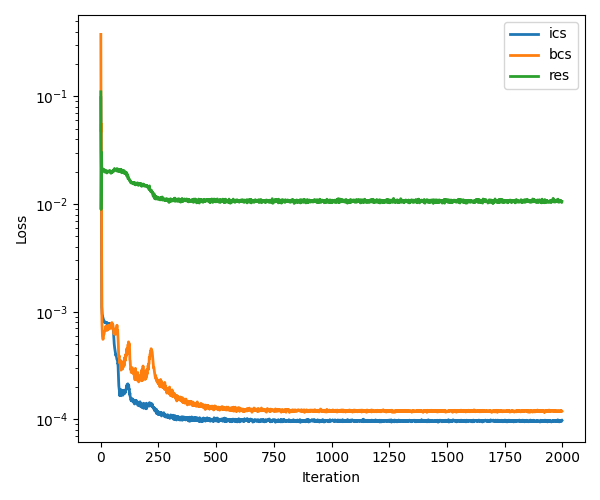

In [ ]:
# Plot for one generated data
k = 103 # index
u = usol[k,:, :]
u0 = usol[k,0,:]

P_test = 101

t = np.linspace(0, 1, P_test)
x = np.linspace(0, 1, P_test)
T, X = np.meshgrid(t, x)

u_test = np.tile(u0, (P_test**2, 1))
y_test = np.hstack([T.flatten()[:,None], X.flatten()[:,None]])
s_test = u.flatten()[:,None]

s_pred = model.predict_s(params, u_test, y_test)[:,None]
S_pred = griddata(y_test, s_pred.flatten(), (T, X), method='cubic')


error_s = np.linalg.norm(u - S_pred.T, 2) / np.linalg.norm(u, 2)

print("error_s: {:.3e}".format(error_s))

fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.pcolor(T, X, u, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $s(x,t)$')
plt.colorbar()
plt.tight_layout()

plt.subplot(1,3,2)
plt.pcolor(T, X, S_pred.T, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $s(x,t)$')
plt.colorbar()
plt.tight_layout()

plt.subplot(1,3,3)
plt.pcolor(T, X, np.abs(S_pred.T - u), cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.colorbar()
plt.tight_layout()
plt.show()

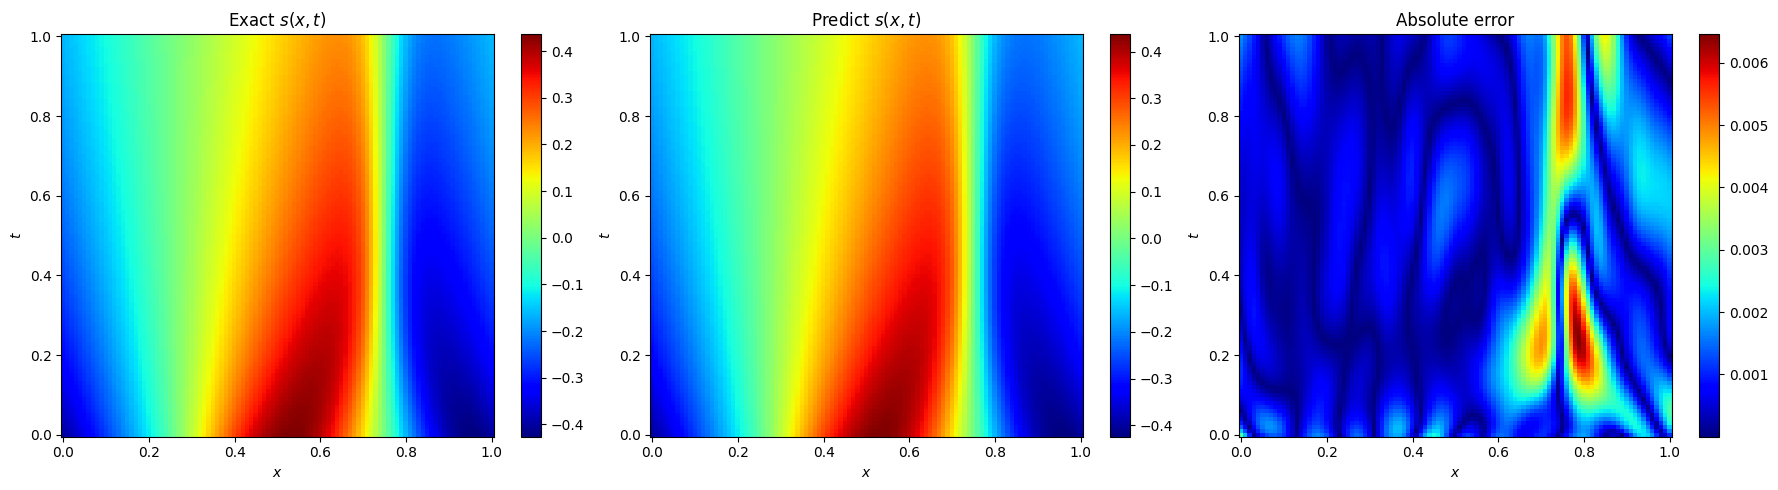

본 페이지는 대한기계학회 고급인공지능 강습회의 가천대학교 김남중 교수님의 "뉴럴 오퍼레이터를 통한 비지도 학습"을 위해 작성된 페이지입니다. 해당 코드는 강연을 위해 약간의 수정이 있는 코드로 구글 코랩을 통해 돌아갈 수 있게 변경되었으니, github 코드를 통해 실행시킬 경우 코드 및 실행 방법이 약간 다를 수 있습니다. 본 페이지는 "Physics-Informed Neural Operator for Learning Partial Differential Equations"를 바탕으로 작성되었습니다.
\
논문 링크 : https://doi.org/10.48550/arXiv.2103.10974
\
Github 링크 : https://github.com/PredictiveIntelligenceLab/Physics-informed-DeepONets.git